In [117]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import umap

from collections import Counter

import spacy

## load files

In [118]:
with open('filtered_speeches.pkl', 'rb') as f:
    df_f = pickle.load(f)

In [119]:
with open('hansard-speeches-post2010.pkl', 'rb') as f:
    df_orig = pickle.load(f)

## get MP party list

In [120]:
MP_party = df_orig[['display_as', 'party']]
MP_party = MP_party.drop_duplicates('display_as').set_index('display_as')

In [121]:
MP_party.head()

,party
display_as,
John Bercow,Speaker
Peter Lilley,Conservative
Donald Foster,Liberal Democrat
Harriet Harman,Labour
David Cameron,Conservative


In [122]:
names = [x[2] for x in df_f.index.values]
parties = [MP_party.loc[MP_name].party for MP_name in names]

In [123]:
corpus = list(df_f.speech.values)
# corpus = list(df.lemmas.apply(lambda x: " ".join(x)).values)

# speech embedding

In [124]:
from sentence_transformers import SentenceTransformer

# embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embedder = SentenceTransformer('paraphrase-mpnet-base-v2')
# embedder = SentenceTransformer('stsb-mpnet-base-v2') #75 max seq length

## count prop. contributions with word/lemma counts above embedder max input sequence length

max sequence length: 128
wordcounts above 128: 88.8642 %
lemmacounts above 128: 59.6062 %


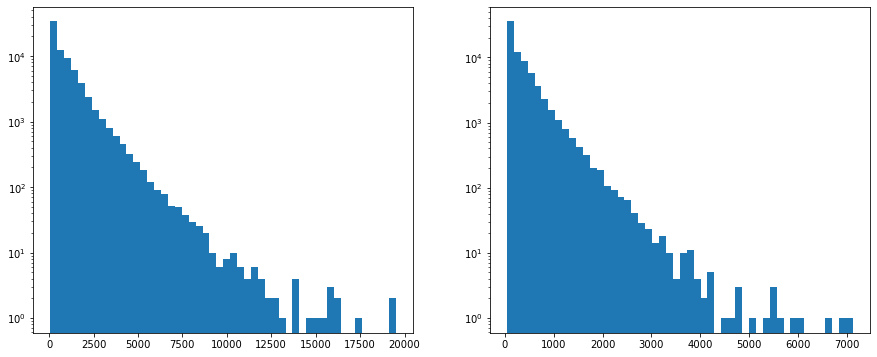

In [125]:
wordcount = df_f.speech.apply(lambda x: len(x.split())).values
lemmacount = df_f.lemmas_ngrams.apply(len).values

max_seq_len = embedder.max_seq_length
print(f'max sequence length: {max_seq_len}')

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].hist(wordcount, bins=50)
ax[0].set_yscale('log')
print(f'wordcounts above {max_seq_len}: {np.around((np.sum(wordcount > max_seq_len) / len(wordcount))*100, 4)} %')

ax[1].hist(lemmacount, bins=50)
ax[1].set_yscale('log')
print(f'lemmacounts above {max_seq_len}: {np.around((np.sum(lemmacount > max_seq_len) / len(lemmacount))*100, 4)} %')

plt.show()

In [126]:
# don't run if loading embeddings
corpus_embeddings = embedder.encode(corpus)
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [127]:
# don't run if loading embeddings
with open('corpus_embeddings_stopspeech_topp_filtered.pkl', 'wb') as f:
    pickle.dump(corpus_embeddings, f)

# run to load embeddings
# with open('corpus_embeddings.pkl', 'rb') as f:
#     corpus_embeddings = pickle.load(f)

In [128]:
corpus_embeddings.shape

(73744, 768)

## PCA dimensionality reduction

In [129]:
np.random.seed(26)

In [130]:
from sklearn.decomposition import PCA
pca = PCA(random_state=26)
pca.fit(corpus_embeddings)

PCA(random_state=26)

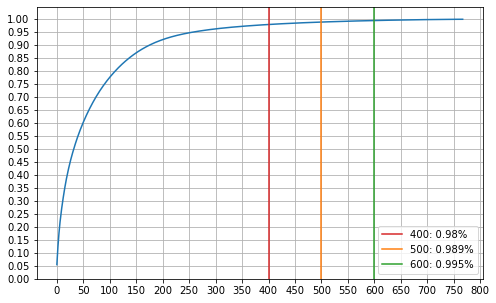

In [131]:
evr = pca.explained_variance_ratio_
cum_evr = [np.sum(evr[:i+1]) for i in range(len(evr))]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cum_evr)
ax.grid()
ax.set_xticks(range(0,801,50))
ax.set_yticks(np.arange(0,1.05,0.05))

v = 400
ax.axvline(v, c='tab:red', label=f'{v}: {np.around(cum_evr[v], 3)}%')

v = 500
ax.axvline(v, c='tab:orange', label=f'{v}: {np.around(cum_evr[v], 3)}%')

v = 600
ax.axvline(v, c='tab:green', label=f'{v}: {np.around(cum_evr[v], 3)}%')

ax.legend()

plt.show()

In [132]:
# don't run if loading embeddings
embeddings = PCA(n_components=500, random_state=26).fit_transform(corpus_embeddings)

## umap dimensionality reduction

In [133]:
np.unique(parties)

array(['Alliance', 'Conservative', 'Democratic Unionist Party',
       'Green Party', 'Independent', 'Labour', 'Labour (Co-op)',
       'Liberal Democrat', 'Plaid Cymru', 'Respect',
       'Scottish National Party', 'Social Democratic & Labour Party',
       'Speaker', 'Ulster Unionist Party'], dtype='<U32')

In [134]:
party_colormap = {
    'Alliance': '#F6CB2F',
    'Conservative': '#0087DC',
    'Democratic Unionist Party': '#D46A4C',
    'Green Party': '#6AB023',
    'Independent': '#DDDDDD',
    'Labour': '#E4003B',
    'Labour (Co-op)': '#E4003B',
    'Liberal Democrat': '#FAA61A',
    'Plaid Cymru': '#008142',
    'Scottish National Party': '#FDF38E',
    'Social Democratic & Labour Party': '#2AA82C',
    'Speaker': '#FFFFFF',
    'Respect': '#46801c',
    'Ulster Unionist Party': '#70147A',
    'nan': '#FFFFFF'
}

c = [party_colormap[str(x)] for x in parties]

In [192]:
# don't run if loading reduced embeddings
reducer = umap.UMAP(n_neighbors=15, 
                    min_dist=0,
                    metric='cosine',
                    low_memory=False)
X = reducer.fit_transform(embeddings) # dimension reduced embedding

In [193]:
# don't run if loading reduced embeddings
# with open('umap_embeddings.pkl', 'wb') as f:
#     pickle.dump(X, f)

# run to load reduced embeddings
# with open('umap_embeddings.pkl', 'rb') as f:
#     X = pickle.load(f)

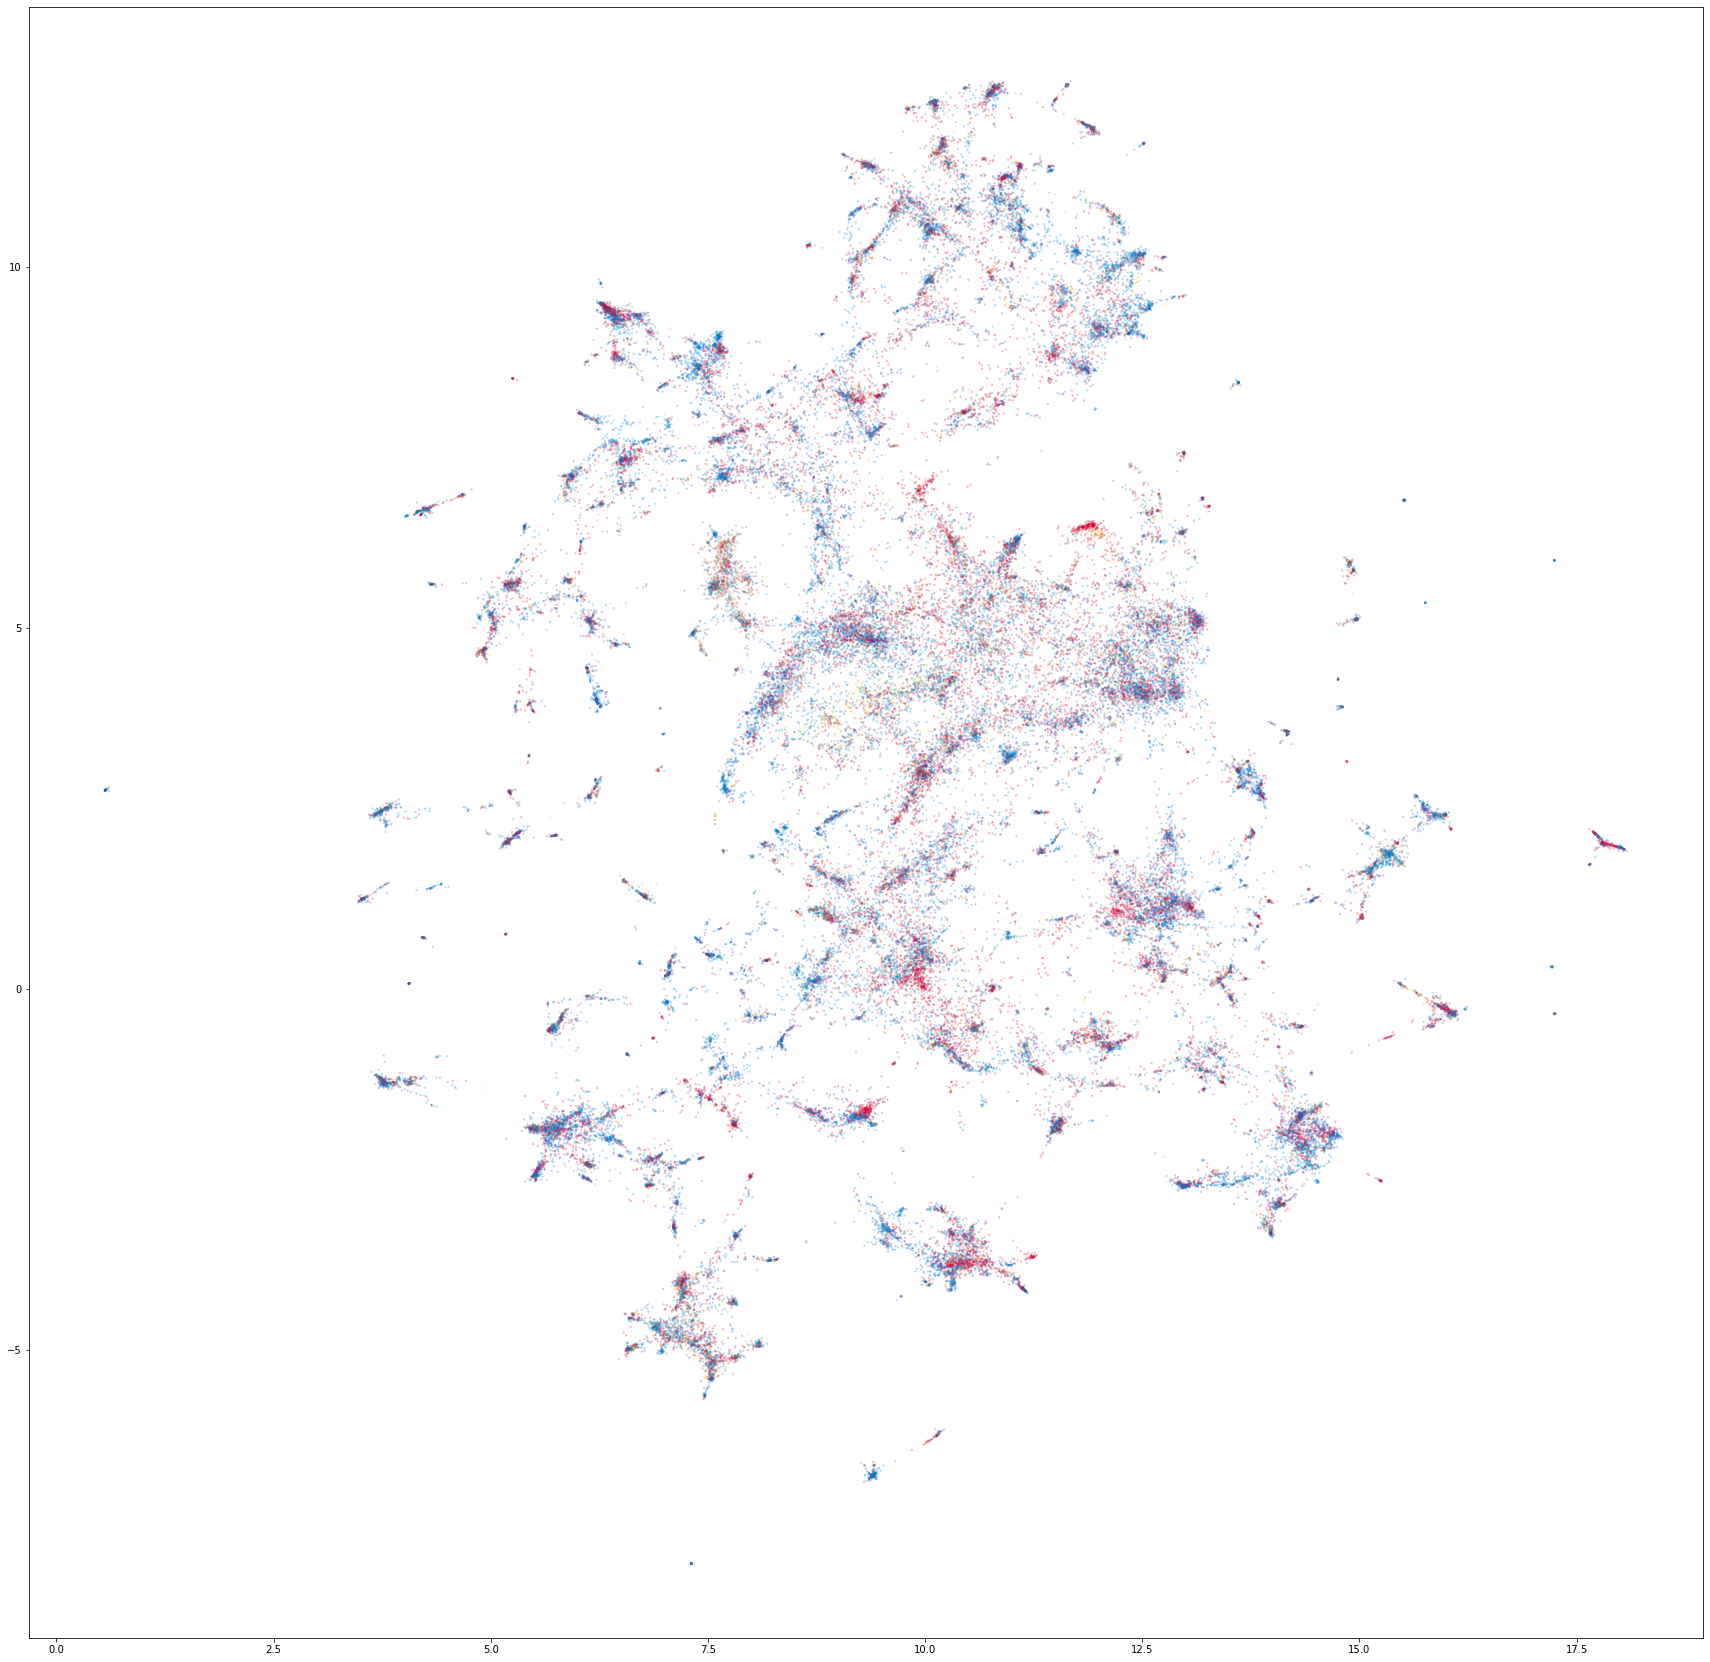

In [194]:
plt.figure(figsize=(30,30))
plt.scatter(X[:,0], X[:,1], s=2, alpha=.2, c=c)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_2.png', dpi=150)
plt.show()

# clustering

In [179]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=40,
                            min_samples=10,
                            cluster_selection_epsilon=0.06,
                            cluster_selection_method='eom')

cluster_labels = clusterer.fit_predict(X)

these parameters tuned manually - for this dataset captures clusters of different sizes and densities well

In [180]:
label_map = np.random.choice(np.arange(len(np.unique(cluster_labels)) - 1), 
                             len(np.unique(cluster_labels)) - 1,
                             replace=False)
label_map = {o:n for o,n in zip(np.arange(len(label_map)), label_map)}
label_map[-1] = -1

cluster_labels = np.array([label_map[x] for x in cluster_labels])

<ipython-input-181-8fd11ad9381c>:2: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))



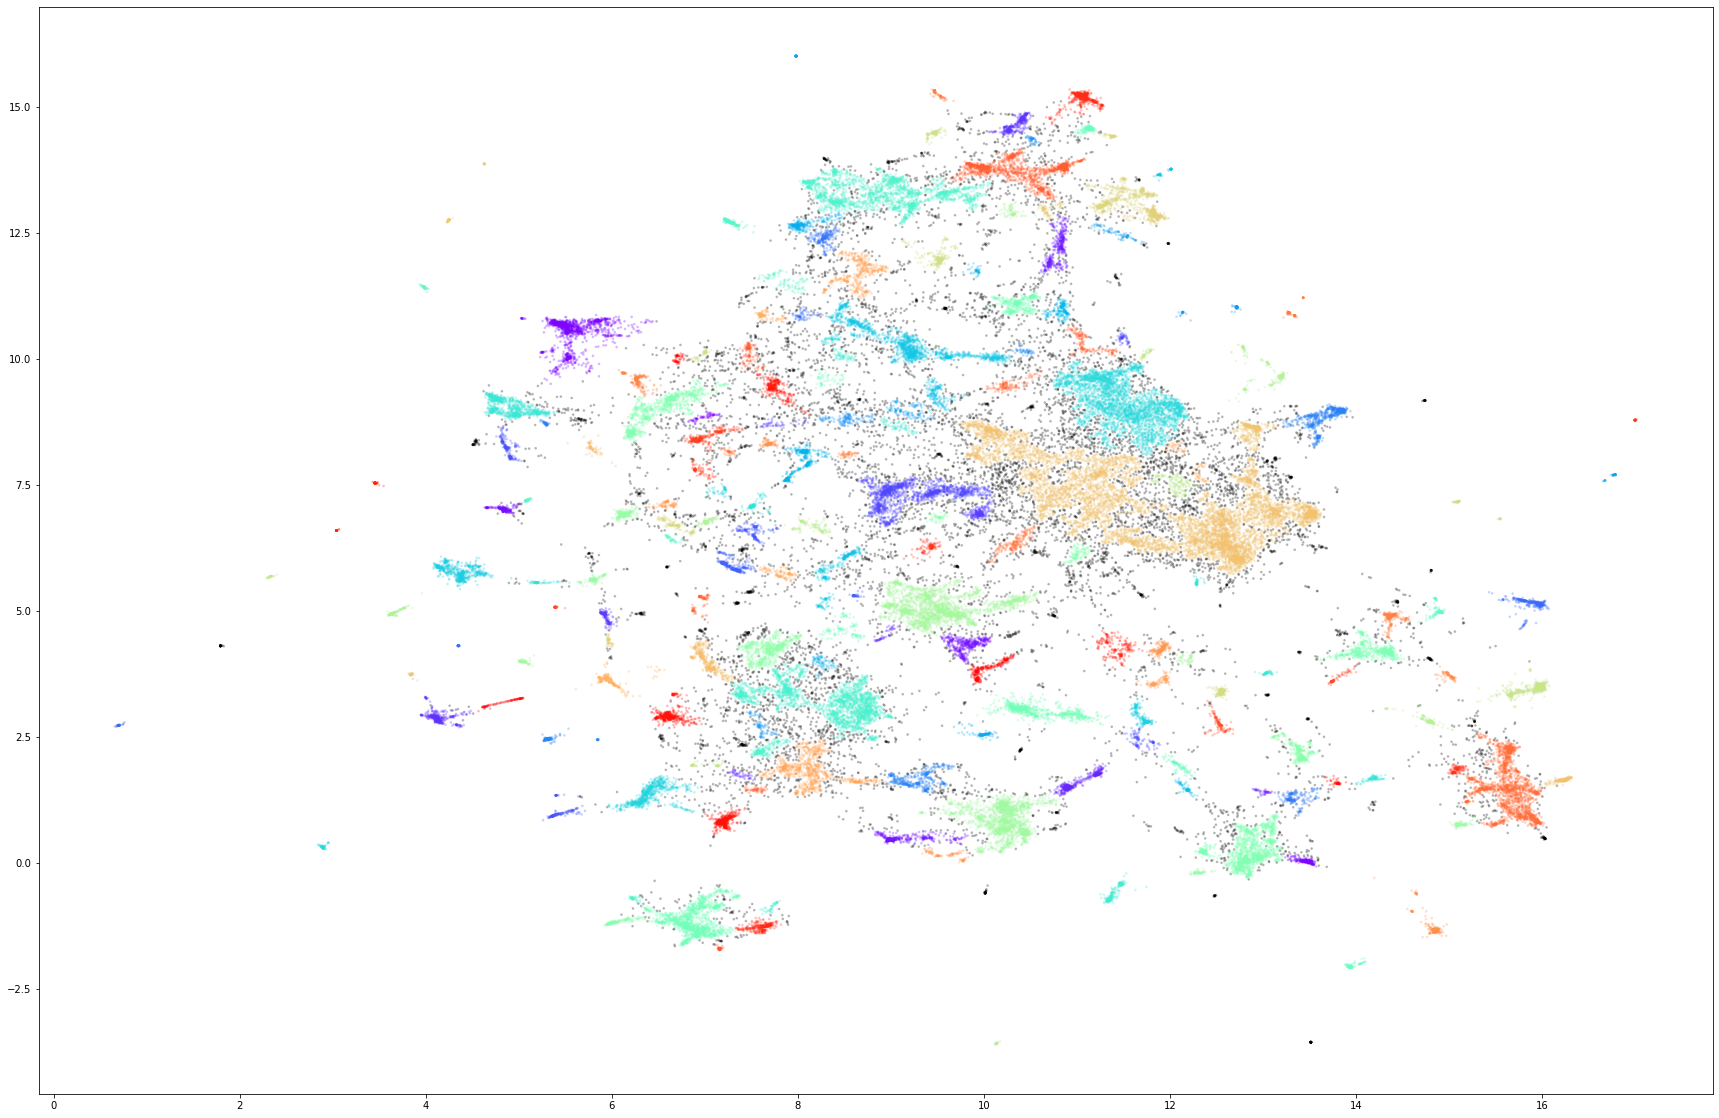

In [181]:
cmap = plt.get_cmap('rainbow')
cmap.set_under('black')  # Color for values less than vmin

plt.figure(figsize=(30,20))
plt.scatter(X[:, 0], X[:, 1], 
            s=3, alpha=.2, c=cluster_labels,
            cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan4.png', dpi=200)
plt.show()

<ipython-input-182-51abcb098c47>:2: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))



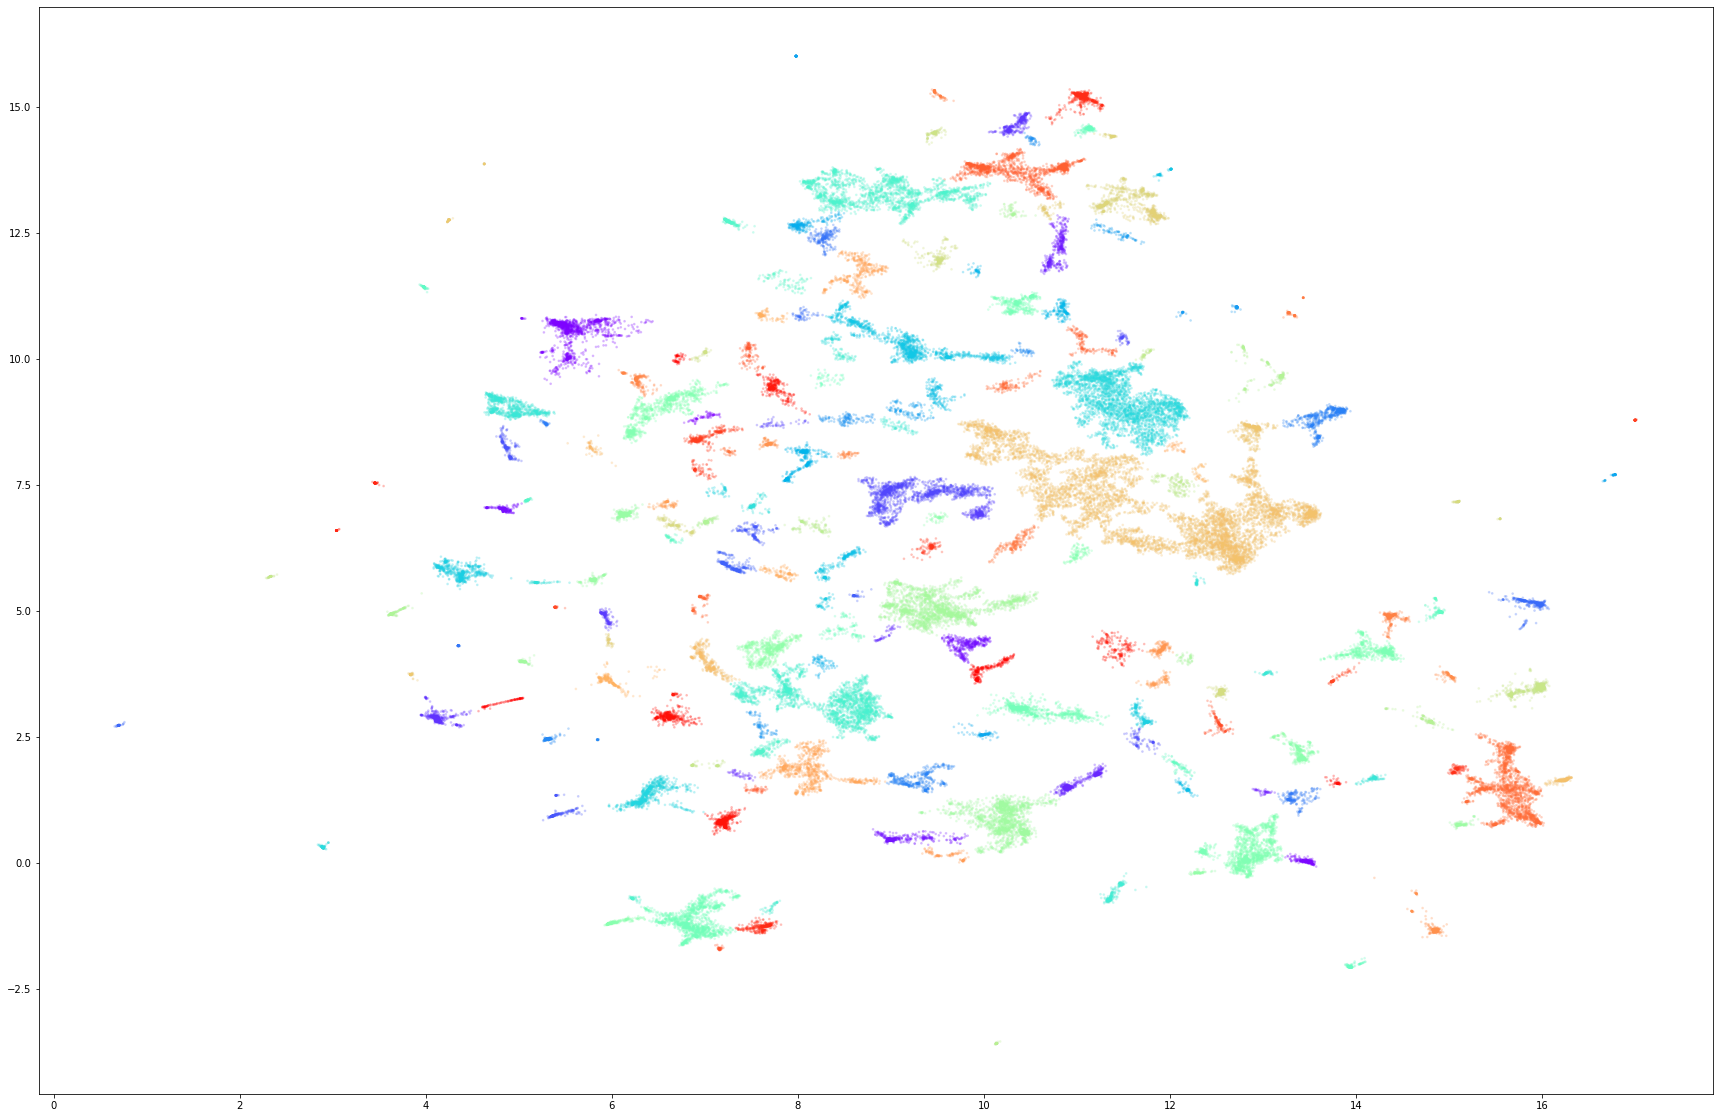

In [182]:
cmap = plt.get_cmap('rainbow')
cmap.set_under('black')  # Color for values less than vmin

plt.figure(figsize=(30,20))
plt.scatter(X[(cluster_labels != -1), 0], X[(cluster_labels != -1), 1], 
            s=3, alpha=.2, c=cluster_labels[(cluster_labels != -1)],
            cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan4.png', dpi=200)
plt.show()

# ploty: interactive scatter & centroids

In [142]:
df_proj = pd.DataFrame(X)
df_proj['cluster'] = cluster_labels

In [143]:
df_proj

,0,1,cluster
0,4.116926,9.567472,30
1,3.000081,11.639894,5
2,2.489622,11.254401,5
3,3.184485,11.209917,5
4,0.490963,7.243027,161
...,...,...,...
73739,3.687752,10.532720,-1
73740,3.682458,11.375148,-1
73741,2.438864,11.468188,5
73742,3.289805,11.212732,5


In [144]:
import plotly.express as px
fig = px.scatter(df_proj, x=0, y=1, 
                 opacity=0.2,
                 color='cluster', hover_data=['cluster'],
                 height=800, width=1200)
fig.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
fig.write_html("clustered_embeddings.html")
# fig.show()

In [145]:
### centroids -- old ###

# df_clusters = df_proj.groupby('cluster').agg({0: ['mean'], 1: ['mean'], 'cluster':[len]})

# X_centroids = df_clusters[[0,1]].values[1:]
# cluster_size = df_clusters['cluster'].values[1:]

# fig, ax = plt.subplots(figsize=(20,20))
# ax.scatter(X_centroids[:,0], X_centroids[:,1], s=cluster_size*3, alpha=0.2)
# for i, txt in enumerate(df_clusters.index.values[1:]):
#     ax.annotate(txt, 
#                 (X_centroids[i,0], X_centroids[i,1]),
#                 ha='center', va='center',
#                 fontsize=10,
#                 alpha=0.5
#                )
# plt.savefig('pp-mpnet-bv2-pca500-nn15-md0-cosine_centroids.png')

# cluster speeches EDA

In [146]:
df_f['cluster'] = cluster_labels

In [147]:
with open(f'filtered_dt.pkl', 'rb') as f:
    dt = pickle.load(f)

N = 90
with open(f'topic-models/coarse/lda_mallet_{N}.pkl', 'rb') as f:
    lda = pickle.load(f)

In [148]:
dt.shape

(93707, 90)

In [149]:
df_f['topic_dist'] = list(dt)

ValueError: Length of values (93707) does not match length of index (73744)

In [ ]:
df_f

In [ ]:
groups = df_f.groupby('cluster')

In [ ]:
df_cluster = groups.agg({'lemmas_ngrams': list})

In [ ]:
df_cluster['topic_dist'] = groups['topic_dist'].apply(np.mean)

In [ ]:
df_cluster['size'] = groups.count().speech

In [ ]:
def flatten(list_of_lists):
    res = []
    for l in list_of_lists:
        res += l
    return res

# def flatten_lemmas(el):
#     return flatten(el.values.ravel()[0])

In [ ]:
df_cluster['lemmas_ngrams'] = df_cluster.lemmas_ngrams.apply(flatten)

In [ ]:
df_cluster

## LDA topic distribution in clusters

In [ ]:
from scipy.stats import entropy
df_cluster['entropy'] = entropy(np.vstack(df_cluster.topic_dist.values), base=2, axis=1)

In [ ]:
df_cluster['I_eff'] = 2 ** df_cluster.entropy

In [ ]:
plt.hist(df_cluster.I_eff, bins=25)
plt.show()

In [ ]:
x = df_cluster['size']
y = df_cluster['I_eff']
plt.scatter(x, y)
plt.xscale('log')

from scipy.stats import pearsonr
print(pearsonr(x,y))

In [ ]:
df_centroids = df_proj.groupby('cluster').agg({0: ['mean'], 1: ['mean'], 'cluster':[len]})[[0,1]]

In [ ]:
df_centroids.head(5)

### tfidf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
dummy = lambda x: x
vectorizer = TfidfVectorizer(max_df=0.8, tokenizer=dummy, lowercase=False)
cluster_tfidf = vectorizer.fit_transform(df_cluster.lemmas_ngrams.values)

In [ ]:
id_to_w = {v:k for k,v in vectorizer.vocabulary_.items()}

In [ ]:
cluster_tfidf_word_ids = np.argsort(cluster_tfidf.toarray(), axis=1)[:, ::-1][:, :10]

In [ ]:
cluster_tfidf_word_ids[0]

In [ ]:
top_vocab_words = np.vectorize(id_to_w.get)(cluster_tfidf_word_ids)

In [ ]:
df_cluster['tfidf_words'] = [" ".join(x) for x in top_vocab_words]

## summarise clusters

In [ ]:
def plot_cluster_topic_dist(cluster_id, df_cluster=df_cluster):
    plt.figure(figsize=(20,5))
    
    dist = df_cluster.loc[cluster_id].topic_dist
    N = len(dist)
    
    mu = np.mean(dist)
    std = np.std(dist)
    
    significant_topic_ids = np.where(np.abs(dist - mu)/std > 1)[0]
    
    colors = np.repeat('k', N)
    colors[significant_topic_ids] = 'r'
    
    plt.bar(np.arange(N), dist,
           color=colors)
    plt.xticks(np.arange(0,N,5))
    
    plt.title(f'cluster {cluster_id} topic distribution')
    plt.show()
    
    order = np.argsort(dist[significant_topic_ids])[::-1]
    return zip(significant_topic_ids[order], dist[significant_topic_ids][order])

def summarise_cluster(cluster_id, df_cluster=df_cluster):
    significant_topic_ids = plot_cluster_topic_dist(cluster_id, df_cluster)
    for topic_id, p in significant_topic_ids:
        print(f'{topic_id}  {np.around(p, 3)}\n{lda.print_topic(topic_id)}\n')
        
    print(f'top tfidf words: {df_cluster.loc[cluster_id, "tfidf_words"]}\n')
    
    print(f"size: {df_cluster.loc[cluster_id,'size']}")
    print(f'centroid: {df_centroids.loc[cluster_id].values}')
    print('\n')

In [ ]:
most_coherent_cluster_ids = df_cluster.sort_values(by='I_eff').head(10).index
df_cluster.loc[most_coherent_cluster_ids]

In [ ]:
for cluster_id in most_coherent_cluster_ids:
    summarise_cluster(cluster_id)

In [ ]:
least_coherent_cluster_ids = df_cluster.sort_values(by='I_eff').tail(10).index
df_cluster.loc[least_coherent_cluster_ids]

In [ ]:
for cluster_id in least_coherent_cluster_ids:
    summarise_cluster(cluster_id)

In [ ]:
df_cluster

In [ ]:
df_cluster.sample(5)

## cluster timeseries

In [ ]:
def plot_cluster_freq(df, i_list, use_top_word=False):
    for i in i_list:
        label = i
        df[df.cluster == i].reset_index().set_index('date').resample('M').agg('count').rename(columns={'heading':label})[label].plot()

In [ ]:
plot_cluster_freq(df_f, [58, 59])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
cluster_lemmas_joined = cluster_lemmas.apply(lambda x: " ".join(x))

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8)
cluster_tfidf = vectorizer.fit_transform(cluster_lemmas_joined)

In [ ]:
# # with open('cluster_tfidf.pkl', 'wb') as f:
# #     pickle.dump(cluster_tfidf, f)

# with open('cluster_tfidf.pkl', 'rb') as f:
#     cluster_tfidf = pickle.load(f)

In [ ]:
cluster_tfidf.shape

In [ ]:
top_vocab_inds = []
non_zero = []
n = 50
for i in range(cluster_tfidf.shape[0]):
    row = cluster_tfidf.getrow(i).toarray().ravel()
    non_zero.append(np.sum(row > 0))
    top_vocab_inds.append(row.argsort()[::-1][:n])
    if i % 100 == 0:
        print(f'done {i}')

In [ ]:
non_zero = np.array(non_zero)

In [ ]:
np.sum(non_zero < n)

In [ ]:
plt.hist(non_zero, bins=500)
plt.xlim((0,10000))
plt.show()

In [ ]:
id_to_w = {v:k for k,v in vectorizer.vocabulary_.items()}

In [ ]:
top_vocab_words = np.vectorize(id_to_w.get)(top_vocab_inds)

In [ ]:
top_vocab_words = [x[:l] for x,l in zip(top_vocab_words, non_zero)]
cluster_vocab = {k:v for k,v in zip(np.arange(len(top_vocab_words))-1, top_vocab_words)}

In [ ]:
cluster_vocab[937]

In [ ]:
cluster_vocab[350]

In [ ]:
cluster_vocab[1266]

In [ ]:
cluster_vocab[267]

In [ ]:
plot_cluster_freq(937)
plot_cluster_freq(350)
plt.legend()
plt.show()

In [ ]:
Counter(cluster_labels).most_common()[:10]

In [ ]:
df[df.cluster==760]

In [ ]:
i = 760
plot_cluster_freq(i)
cluster_vocab[i]

In [ ]:
# for i, vocab in cluster_vocab.items():
#     print(i, vocab[:10], '\n')